# Imports

In [431]:
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, Pool
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras import metrics

from src.data.data_preprocessors import DataPreprocessor
from src.data.data_loaders import DataLoader
from src.data.data_savers import DataSaver

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [430]:
DATA_DIR = Path('/home/ilya/Тестовые/datalouna/data/raw')
PREDICTS_DIR = Path('/home/ilya/Тестовые/datalouna/data/predicts')

In [5]:
data_loader = DataLoader()
train_data, players_data, test_data = data_loader.load_data(data_dir=DATA_DIR)

In [438]:
test_data = test_data.drop(columns='index')

,map_id,team1_id,team2_id,map_name
0,309,5973,5752,Dust2
1,541,5973,5752,Vertigo
2,1,8297,7020,Nuke
3,392,8297,7020,Mirage
4,684,8297,7020,Overpass
5,85,4494,4411,Vertigo
6,314,4494,4411,Inferno
7,403,4494,4411,Mirage
8,125,4608,7718,Inferno
9,241,4608,7718,Mirage


# EDA

In [11]:
print(f"Train shape: {train_data.shape}")
print(f"Test shape: {test_data.shape}")

Train shape: (713, 5)
Test shape: (30, 5)


**Имеем 30 карт в тестовом датасете и 713 в тренировочном**

In [12]:
players_data[[column for column in players_data.columns.tolist() if 'p1' in column]]

,p1_id,p1_total_kills,p1_headshots,p1_total_deaths,p1_kd_ratio,p1_damage_per_round,p1_grenade_damage_per_round,p1_maps_played,p1_rounds_played,p1_kills_per_round,...,p1_kill_death,p1_kill_round,p1_rounds_with_kills,p1_kill_death_difference,p1_total_opening_kills,p1_total_opening_deaths,p1_opening_kill_ratio,p1_opening_kill_rating,p1_team_win_percent_after_first_kill,p1_first_kill_in_won_rounds
0,4954,90,42.2,112,0.80,76.3,5.9,6,156,0.58,...,0.80,0.58,62,-22,10,13,0.77,0.85,60.0,8.2
1,5794,45,60.0,57,0.79,82.3,10.9,3,68,0.66,...,0.79,0.66,30,-12,5,10,0.50,0.79,40.0,10.0
2,4954,156,51.9,167,0.93,63.5,3.4,10,265,0.59,...,0.93,0.59,107,-11,21,18,1.17,0.95,81.0,13.1
3,5794,449,53.5,427,1.05,86.7,13.1,23,618,0.73,...,1.04,0.72,267,18,53,54,0.98,0.96,83.0,14.1
4,7998,173,32.9,130,1.33,82.4,2.9,9,225,0.77,...,1.33,0.77,120,43,41,17,2.41,1.45,82.9,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1481,9031,69,49.3,70,0.99,69.8,5.7,4,114,0.61,...,0.99,0.61,45,-1,7,11,0.64,0.81,85.7,10.7
1482,7716,104,55.8,113,0.92,71.6,5.9,6,172,0.60,...,0.92,0.60,81,-9,15,16,0.94,0.95,86.7,14.8
1483,12521,141,37.6,159,0.89,79.7,7.4,8,210,0.67,...,0.86,0.65,80,-20,36,37,0.97,1.28,75.0,23.3
1484,7716,155,58.7,154,1.01,71.1,7.9,10,246,0.63,...,1.00,0.63,74,0,12,15,0.80,0.87,91.7,10.1


**Для каждого игрока по каждой карте имеем 24 фичи**

# Preprocess data for models

In [391]:
%%time
preprocessor = DataPreprocessor()
players_data_processed = preprocessor.preprocess(matches_data=train_data,
                                                 players_data=players_data)

/home/ilya/Тестовые/datalouna/src/data/data_preprocessors.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return: pd.DataFrame - transformed players info DataFrame
/home/ilya/Тестовые/datalouna/src/data/data_preprocessors.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return: pd.DataFrame - transformed players info DataFrame
/home/ilya/Тестовые/datalouna/src/data/data_preprocessors.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

CPU times: user 44.4 s, sys: 60.9 ms, total: 44.5 s
Wall time: 56 s


In [392]:
players_data_processed

,map_id,team1_id,team2_id,map_name,who_win,p1_total_kills_first,p1_headshots_first,p1_total_deaths_first,p1_kd_ratio_first,p1_damage_per_round_first,...,p4_vs_p1_first_kill_in_won_rounds,p4_vs_p2_first_kill_in_won_rounds,p4_vs_p3_first_kill_in_won_rounds,p4_vs_p4_first_kill_in_won_rounds,p4_vs_p5_first_kill_in_won_rounds,p5_vs_p1_first_kill_in_won_rounds,p5_vs_p2_first_kill_in_won_rounds,p5_vs_p3_first_kill_in_won_rounds,p5_vs_p4_first_kill_in_won_rounds,p5_vs_p5_first_kill_in_won_rounds
0,289,6665,7718,Ancient,0,0.076685,-0.811992,0.521746,-0.864797,-0.276583,...,-0.593544,-2.951234,0.379209,-0.791392,-1.961993,1.483860,-0.873829,2.456613,1.286012,0.115411
1,715,4411,10577,Inferno,0,-0.536757,-0.509417,-0.197451,-0.955303,-0.908009,...,1.764145,1.500348,1.764145,1.384936,-0.016487,0.626519,0.362721,0.626519,0.247310,-1.154114
2,157,11251,9455,Nuke,1,1.886339,0.728388,1.401704,0.764303,1.789081,...,0.923291,0.923291,0.461645,1.071677,0.758418,-1.566297,-1.566297,-2.027943,-1.417911,-1.731171
3,524,4608,7532,Mirage,0,1.732979,-1.444647,0.614818,2.212392,1.148635,...,-2.126867,-0.494620,-2.341202,-0.016487,-0.082437,0.000000,1.632247,-0.214335,2.110379,2.044430
4,404,8637,6667,Overpass,1,-0.237704,1.003456,0.140995,-0.864797,-0.844866,...,0.807880,0.494620,-0.593544,0.939778,0.939778,0.626519,0.313259,-0.774905,0.758418,0.758418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,709,6667,4773,Inferno,0,0.552103,0.269942,1.393243,-1.181566,-0.267563,...,-0.263797,-0.824367,-0.511107,-0.626519,-0.131899,-0.708956,-1.269525,-0.956266,-1.071677,-0.577057
709,528,9215,5995,Ancient,1,-0.345056,0.489996,-0.848959,2.167139,0.715658,...,1.846582,-0.857342,0.263797,1.665221,3.429366,2.374177,-0.329747,0.791392,2.192816,3.956961
710,163,4869,9565,Mirage,1,1.525942,-0.050971,2.594725,-1.091061,-0.808785,...,0.065949,0.395696,0.148386,-0.098924,0.989240,-0.214335,0.115411,-0.131899,-0.379209,0.708956
711,96,10426,4991,Nuke,1,1.924680,-0.160998,2.036290,-0.050247,-0.033033,...,-0.065949,-1.154114,-0.972753,-0.544082,-0.346234,0.214335,-0.873829,-0.692468,-0.263797,-0.065949


In [421]:
x_test = preprocessor.merge_players_with_matches(test_data)
x_test = x_test.drop(columns=[f"p{i}_id_{side}" for i in range(1, 6) for side in ['first', 'second']])
x_test = preprocessor.add_features(x_test)

/home/ilya/Тестовые/datalouna/src/data/data_preprocessors.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return: pd.DataFrame - transformed players info DataFrame
/home/ilya/Тестовые/datalouna/src/data/data_preprocessors.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return: pd.DataFrame - transformed players info DataFrame
/home/ilya/Тестовые/datalouna/src/data/data_preprocessors.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

,map_id,team1_id,team2_id,map_name,p1_total_kills_first,p1_headshots_first,p1_total_deaths_first,p1_kd_ratio_first,p1_damage_per_round_first,p1_grenade_damage_per_round_first,...,p4_vs_p1_first_kill_in_won_rounds,p4_vs_p2_first_kill_in_won_rounds,p4_vs_p3_first_kill_in_won_rounds,p4_vs_p4_first_kill_in_won_rounds,p4_vs_p5_first_kill_in_won_rounds,p5_vs_p1_first_kill_in_won_rounds,p5_vs_p2_first_kill_in_won_rounds,p5_vs_p3_first_kill_in_won_rounds,p5_vs_p4_first_kill_in_won_rounds,p5_vs_p5_first_kill_in_won_rounds
0,309,5973,5752,Dust2,-1.096522,0.774232,-1.043565,-0.457522,-0.312664,0.598147,...,1.516835,3.132594,1.830095,1.220063,1.220063,0.890316,2.506075,1.203576,0.593544,0.593544
1,541,5973,5752,Vertigo,-0.138019,-0.243518,0.098689,-0.548028,-0.511113,0.637676,...,-0.329747,0.989240,-0.329747,-0.230823,-1.351962,-0.082437,1.236550,-0.082437,0.016487,-1.104652
2,1,8297,7020,Nuke,0.168702,-0.206843,0.868653,-1.181566,0.427006,-0.113379,...,0.313259,-0.395696,-0.494620,-2.440126,-0.890316,0.610032,-0.098924,-0.197848,-2.143354,-0.593544
3,392,8297,7020,Mirage,0.391074,-0.436066,0.733274,-0.593280,0.381904,-0.192438,...,-0.098924,0.214335,0.708956,-0.197848,2.242278,-0.774905,-0.461645,0.032975,-0.873829,1.566297
4,684,8297,7020,Overpass,-0.927826,-0.216011,-0.781269,-0.729039,0.066191,-0.824905,...,0.758418,-0.263797,1.286012,-1.170601,-1.813607,0.148386,-0.873829,0.675981,-1.780633,-2.423639
5,85,4494,4411,Vertigo,-0.007663,-0.252687,0.327140,-0.729039,0.345822,0.795793,...,-0.840854,-1.731171,-0.956266,0.131899,-0.329747,-0.725443,-1.615759,-0.840854,0.247310,-0.214335
6,314,4494,4411,Inferno,0.398742,0.655036,1.071720,-1.045808,-0.493072,0.716734,...,0.098924,0.197848,0.379209,-1.500348,0.840854,-0.873829,-0.774905,-0.593544,-2.473101,-0.131899
7,403,4494,4411,Mirage,-0.046003,0.581685,0.767119,-1.453083,-1.016253,-0.311025,...,-0.082437,0.247310,0.675981,-1.302500,1.665221,-0.395696,-0.065949,0.362721,-1.615759,1.351962
8,125,4608,7718,Inferno,0.383406,0.159914,-0.087456,1.262084,1.283941,0.044738,...,-0.412183,-2.967721,-0.329747,-1.071677,-0.494620,0.032975,-2.522563,0.115411,-0.626519,-0.049462
9,241,4608,7718,Mirage,2.124048,-1.160411,0.919419,2.121886,1.166676,-1.101609,...,-0.972753,-0.774905,-0.972753,-1.879557,-0.972753,0.807880,1.005728,0.807880,-0.098924,0.807880


In [422]:
cat_features = ['team1_id', 'team2_id', 'map_name']

In [423]:
target = 'who_win'

Категориальные признаки показали себя плохо, а для нейросети и логистической регрессии их нужно дополнительно предобрабатывать, поэтому выкинем их из датасета

In [424]:
x = players_data_processed.drop(columns=[target, 'map_id'] + cat_features)
x_test = x_test.drop(columns=['map_id'] + cat_features)

y = players_data_processed[[target]]

In [425]:
x = x.fillna(0)

In [426]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3)

# Catboost

In [401]:
params = {'verbose': 200,
          'iterations': 1000,
          'eval_metric': 'AUC'}

In [402]:
model_ctb = CatBoostClassifier(**params)

In [403]:
train_pool = Pool(data=x_train, label=y_train)
val_pool = Pool(data=x_val, label=y_val)

In [404]:
model_ctb.fit(train_pool, eval_set=val_pool)

Learning rate set to 0.026689
0:	test: 0.5835822	best: 0.5835822 (0)	total: 237ms	remaining: 3m 56s
200:	test: 0.6024075	best: 0.6300118 (15)	total: 17.1s	remaining: 1m 7s
400:	test: 0.6104625	best: 0.6300118 (15)	total: 37.1s	remaining: 55.5s
600:	test: 0.6036745	best: 0.6300118 (15)	total: 56.1s	remaining: 37.3s
800:	test: 0.6060277	best: 0.6300118 (15)	total: 1m 15s	remaining: 18.8s
999:	test: 0.6047606	best: 0.6300118 (15)	total: 1m 34s	remaining: 0us

bestTest = 0.6300117658
bestIteration = 15

Shrink model to first 16 iterations.


In [405]:
predicts_ctb = model_ctb.predict_proba(val_pool)[:, 1]

In [406]:
roc_auc_score(y_val, predicts_ctb)

0.630011765770658

# Neural network

In [408]:
model_nn = keras.Sequential([
    layers.Dense(x_train.shape[1], activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
])

In [409]:
model_nn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[metrics.AUC()]
)

In [410]:
history = model_nn.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=1024,
    epochs=30,
    verbose=100
)

Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30


<AxesSubplot: title={'center': 'AUC'}>

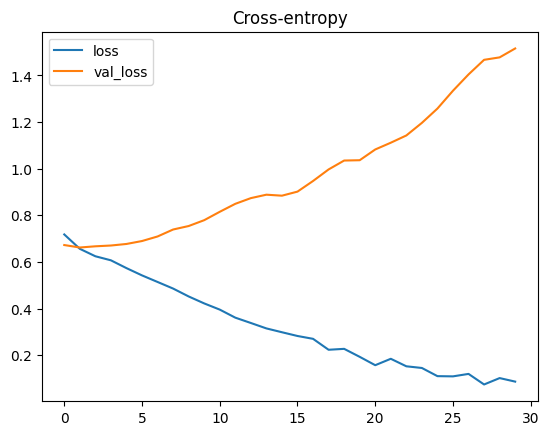

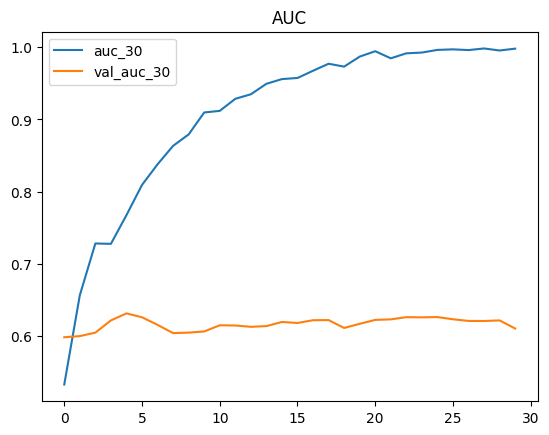

In [411]:
history_df = pd.DataFrame(history.history)
history_df.iloc[:, [0, 2]].plot(title="Cross-entropy")
history_df.iloc[:, [1, 3]].plot(title="AUC")

In [412]:
predicts_nn = model_nn.predict(x_val)
roc_auc_score(y_val, predicts_nn)

7/7 [==============================] - 0s 2ms/step


0.6190605484659245

# Logistic regression

In [414]:
lr_model = LogisticRegression()

In [415]:
lr_model.fit(x_train, y_train)

/home/ilya/Тестовые/datalouna/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ilya/Тестовые/datalouna/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [416]:
predicts_lr = lr_model.predict_proba(x_val)[:, 1]
roc_auc_score(y_val, predicts_lr)

0.6316408724771473

# Make predicts

In [442]:
predicts_list = list()

In [443]:
test_data[target] = lr_model.predict_proba(x_test)[:, 1]
predicts_list.append(test_data.loc[:, ['map_id', target]])

In [444]:
test_data[target] = model_ctb.predict_proba(x_test)[:, 1]
predicts_list.append(test_data.loc[:, ['map_id', target]])

In [445]:
test_data[target] = model_nn.predict(x_test)
predicts_list.append(test_data.loc[:, ['map_id', target]])

1/1 [==============================] - 0s 46ms/step


In [447]:
data_saver = DataSaver()
data_saver.save(save_dir=PREDICTS_DIR, content=predicts_list)